# Random search model selection for Emoji-predictors for Spanish tweets
Author: Eric S. Tellez -- [donsadit@gmail.com](mailto:donsadit@gmail.com)

## Abstract
This scripts shows how perform random search over a space of configurations to select a model that predicts the related emoji for a given short text.
The text model is based on the Entropy based weighting; we can reduce the size of the model using prunning techniques.
This example uses a Rocchio classifier.

## Example

The first step is to initialize the environment

In [1]:
using Pkg
pkg"activate ."
# uncomment to install the required packages
# pkg"add https://github.com/sadit/SimilaritySearch.jl https://github.com/sadit/TextSearch.jl https://github.com/sadit/KernelMethods.jl Random StatsBase CSV DataFrames StatsPlots IterTools"
using SimilaritySearch, TextSearch, Random, StatsBase, KernelMethods, CSV, DataFrames, StatsPlots, SparseArrays, IterTools

# fetching data
url = "http://ingeotec.mx/~sadit/emotions.csv"
!isfile(basename(url)) && download(url, basename(url))
db = DataFrame(CSV.read(basename(url)))

Activating environment at `~/Research/TextSearch.jl/examples/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/sadit/SimilaritySearch.jl`
  Updating git-repo `https://github.com/sadit/SimilaritySearch.jl`
  Updating git-repo `https://github.com/sadit/TextSearch.jl`
  Updating git-repo `https://github.com/sadit/TextSearch.jl`
  Updating git-repo `https://github.com/sadit/KernelMethods.jl`
  Updating git-repo `https://github.com/sadit/KernelMethods.jl`
 Resolving package versions...
  Updating `~/Research/TextSearch.jl/examples/Project.toml`
  [7f6f6c8a] ~ TextSearch v0.3.1 #master (https://github.com/sadit/TextSearch.jl)
  Updating `~/Research/TextSearch.jl/examples/Manifest.toml`
  [7f6f6c8a] ~ TextSearch v0.3.1 #master (https://github.com/sadit/TextSearch.jl)


┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/SimilaritySearch/D8LfQ.ji for SimilaritySearch [053f045d-5466-53fd-b400-a066f88fe02a]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/TextSearch/mqUEb.ji for TextSearch [7f6f6c8a-3b03-11e9-223d-e7d88259bd6c]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/KernelMethods/lt5mb.ji for KernelMethods [d79e8f30-5872-11e9-0dab-2d1842b87615]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1240


,klass,text
,String,String
1,😰,@DanuFSanz Me gustaría amika pero tengo una panza enorme _emo_
2,😥,"Debería de estar en mi casa, no aquí sufriendo porque no hay luz _emo_"
3,😊,@PowerMusicRadio _emo_ Voto X #HayAmores de @julionalvarez para que ingrese en él #TopPower con @yuyu_perez @NoticiasJulion @ViejonasJAySNB
4,♡,@CelopanYT Muy buenos días bae _emo_
5,💔,"@IsamarPortilla Gracias no era necesario, después de que me rompes el corazón _emo_"
6,🙂,Buena idea venir a mis trámites donde hubiera mi gym pa desestresarme! _emo_ (at @SmartFit_mex) _url_ _url_
7,😋,Lasaña!!!. _emo_ _emo_ _emo_ @ Postodoro Xalapa Centro _url_
8,😊,Hay que aprender a vivir nuestra vida y dejar a los demás vivir la suya _emo_
9,♡,Tu por siempre _emo_ _url_


## Partitioning the data

We take a small sample for training and validation collections to estimate the performance of our predictions; here we use a siholdout scheme for cross-validation.

In [2]:
function sample_and_partition(db, n, p)
    m = round(Int, n * p)
    G = db[sample(1:size(db, 1), n), :]
    corpus_train = G.text[1:m]
    corpus_test = G.text[m+1:end]
    labels_train = G.klass[1:m]
    labels_test = G.klass[m+1:end]
    le = fit(LabelEncoder, labels_train)
    labels_train = KernelMethods.transform.(le, labels_train)
    labels_test = KernelMethods.transform.(le, labels_test)

    (corpus_train=corpus_train, labels_train=labels_train, corpus_test=corpus_test, labels_test=labels_test, le=le)
end


sample_and_partition (generic function with 1 method)

## Random searching for models
The following functions runs and evaluate a random subset of configurations from a relatively large grid of parameters. Contrary to other examples, the TextConfig is also varied. Notice that we fixed $p=0.1$ such that the resulting vocabulary model contains just a tenth percent of the tokens; models with higher scores can be found if the size of the vocabulary is not limited, but the memory impact can be of matter.

................................

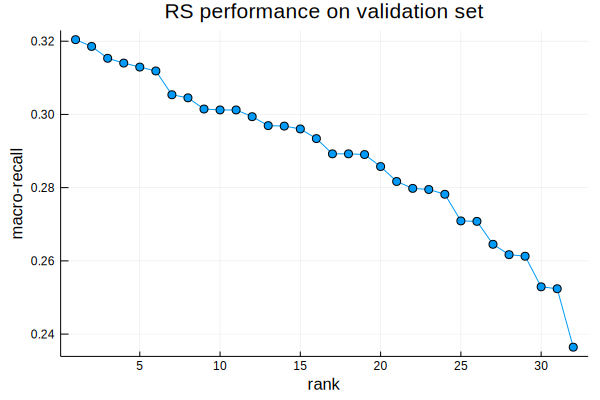

finished


In [22]:
function evaluate_model(part, config, kind, vkind, p)
    model = fit(kind, config, part.corpus_train, part.labels_train, smooth=0.0)
    if p < 1.0
        model = prune_select_top(model, p)
    end
    Xtrain = [vectorize(model, vkind, text) for text in part.corpus_train]
    Xtest = [vectorize(model, vkind, text) for text in part.corpus_test]
    classifier = fit(Rocchio, Xtrain, part.labels_train)
    ypred = predict.(classifier, Xtest)
    s = scores(part.labels_test, ypred)
    delete!(s, :class_precision); delete!(s, :class_recall); delete!(s, :class_f1)
    (p=p, config=config, kind=kind, vkind=vkind, score=s[:macro_recall], scores=s, voc=length(model.tokens))
end

function select_from_power_set(set, k, lowersize, uppersize)
    lst = collect(subsets(set))
    lst = filter(x -> lowersize <= length(x) <= uppersize, lst)
    rand(lst, k)
end

function random_search(db, sample_size, p)
    part = sample_and_partition(db, 5000, 0.7)
    qlist_ = select_from_power_set([3, 4, 5, 6, 7], sample_size, 1, 3)
    nlist_ = select_from_power_set([1, 2, 3], sample_size, 0, 2)
    slist_ = select_from_power_set([(2, 1), (2, 2)], sample_size, 0, 1)
    
    kind = EntModel
    
    L = []
    for i in 1:sample_size
        qlist = qlist_[i]
        nlist = nlist_[i]
        slist = slist_[i]

        config = TextConfig(qlist=qlist, nlist=nlist, slist=slist)
        vkind = rand([EntModel, EntTfModel, EntTpModel])   
        
        perf = evaluate_model(part, config, kind, vkind, p)
        print(".")
        push!(L, perf)
    end
    println("finished")
    L
end

P = DataFrame(random_search(db, 32, 0.1))
sort!(P, :score, rev=true)
plot(P.score, label="", xlabel="rank", ylabel="macro-recall", markershape=:auto, title="RS performance on validation set") |> display

In [25]:
@info P.score
ratio = 0.9
part_large = sample_and_partition(db, size(db, 1), ratio)
F = []
for (i, row) in enumerate(eachrow(sort!(P, :score, rev=true)))
    print(stderr, "evaluating config with rank $i: prev-score=$(row.score), ")
    push!(F, evaluate_model(part_large, row.config, row.kind, row.vkind, row.p).score)
    println(stderr, "curr-score=$(F[end])")
end

┌ Info: [0.32042715272018063, 0.3185739155483826, 0.31533110813689336, 0.31402672339075405, 0.3129331728117654, 0.31187013162205457, 0.3053768339205358, 0.30452956848169366, 0.30147559388702455, 0.30122761310634577, 0.30122645774997814, 0.29938632501477064, 0.296945021481935, 0.29681222227505677, 0.2960365812183918, 0.29339949889684475, 0.289235128661099, 0.289235128661099, 0.28904617205087085, 0.2857655738801126, 0.2816846237193883, 0.27980035248206114, 0.2794998890521838, 0.27818949309814145, 0.2709147453775752, 0.27079005973657216, 0.2645275668185746, 0.2616996755209355, 0.2612707060527937, 0.25291312748286865, 0.25239101331596997, 0.236423771488865]
└ @ Main In[25]:1
evaluating config with rank 1: prev-score=0.32042715272018063, curr-score=0.6201552248288218
evaluating config with rank 2: prev-score=0.3185739155483826, curr-score=0.622913438137976
evaluating config with rank 3: prev-score=0.31533110813689336, curr-score=0.6173779149734977
evaluating config with rank 4: prev-score=0

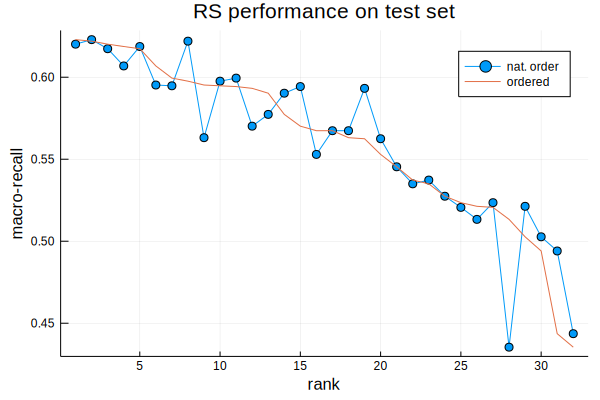

In [26]:

plot(F, label="nat. order", xlabel="rank", ylabel="macro-recall", markershape=:auto, title="RS performance on test set")
plot!(sort(F, rev=true), label="ordered")
